## **Mount Google Drive & Download Dataset**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
import zipfile
with zipfile.ZipFile("plantvillage-dataset.zip","r") as zip_ref:
    zip_ref.extractall("plantvillage")

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.03G/2.04G [00:16<00:00, 258MB/s]
100% 2.04G/2.04G [00:16<00:00, 131MB/s]


In [ ]:
import os

data_dir = "plantvillage/plantvillage dataset/color"

print("Number of categories:", len(os.listdir(data_dir)))
print("First 5 categories:", os.listdir(data_dir)[:5])

Number of categories: 38
First 5 categories: ['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy', 'Potato___Late_blight', 'Tomato___Target_Spot', 'Corn_(maize)___healthy']


### **Key Insight**

We observe a clear and consistent naming pattern in the categories:

- **Format:** PlantName___Condition
- **Examples:**
  - Grape___healthy : A **healthy** grape leaf
  - Tomato___Septoria_leaf_spot : A tomato leaf with **Septoria leaf spot** disease

  
---

## **Import Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
import random

# **Exploratory Data Analysis (EDA) -Flora 🌿**

---




## **Show sample images**

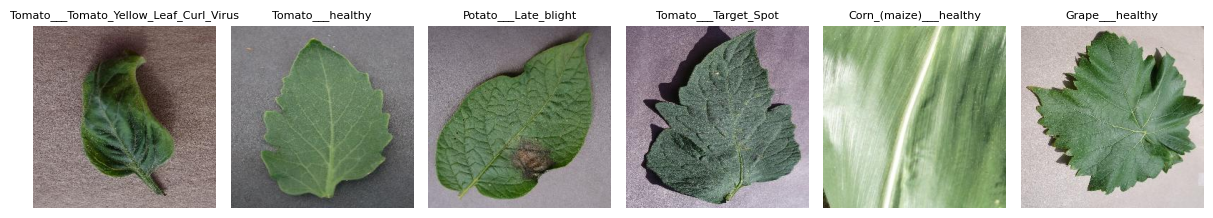

In [ ]:
categories = os.listdir(data_dir)
plt.figure(figsize=(12, 4))
for i, category in enumerate(categories[:6]):
    category_path = os.path.join(data_dir, category)
    img_name = os.listdir(category_path)[0]
    img_path = os.path.join(category_path, img_name)

    img = Image.open(img_path)

    plt.subplot(1, 6, i+1)
    plt.imshow(img)
    plt.title(category, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Count images per category**



In [ ]:
image_counts = {c: len(os.listdir(os.path.join(data_dir, c))) for c in categories}
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Category', 'Number of Images'])
df_counts = df_counts.sort_values(by='Number of Images', ascending=False)
df_counts.reset_index(drop=True, inplace=True)
df_counts

,Category,Number of Images
0,Orange___Haunglongbing_(Citrus_greening),5507
1,Tomato___Tomato_Yellow_Leaf_Curl_Virus,5357
2,Soybean___healthy,5090
3,Peach___Bacterial_spot,2297
4,Tomato___Bacterial_spot,2127
5,Tomato___Late_blight,1909
6,Squash___Powdery_mildew,1835
7,Tomato___Septoria_leaf_spot,1771
8,Tomato___Spider_mites Two-spotted_spider_mite,1676
9,Apple___healthy,1645


## **Image distribution**

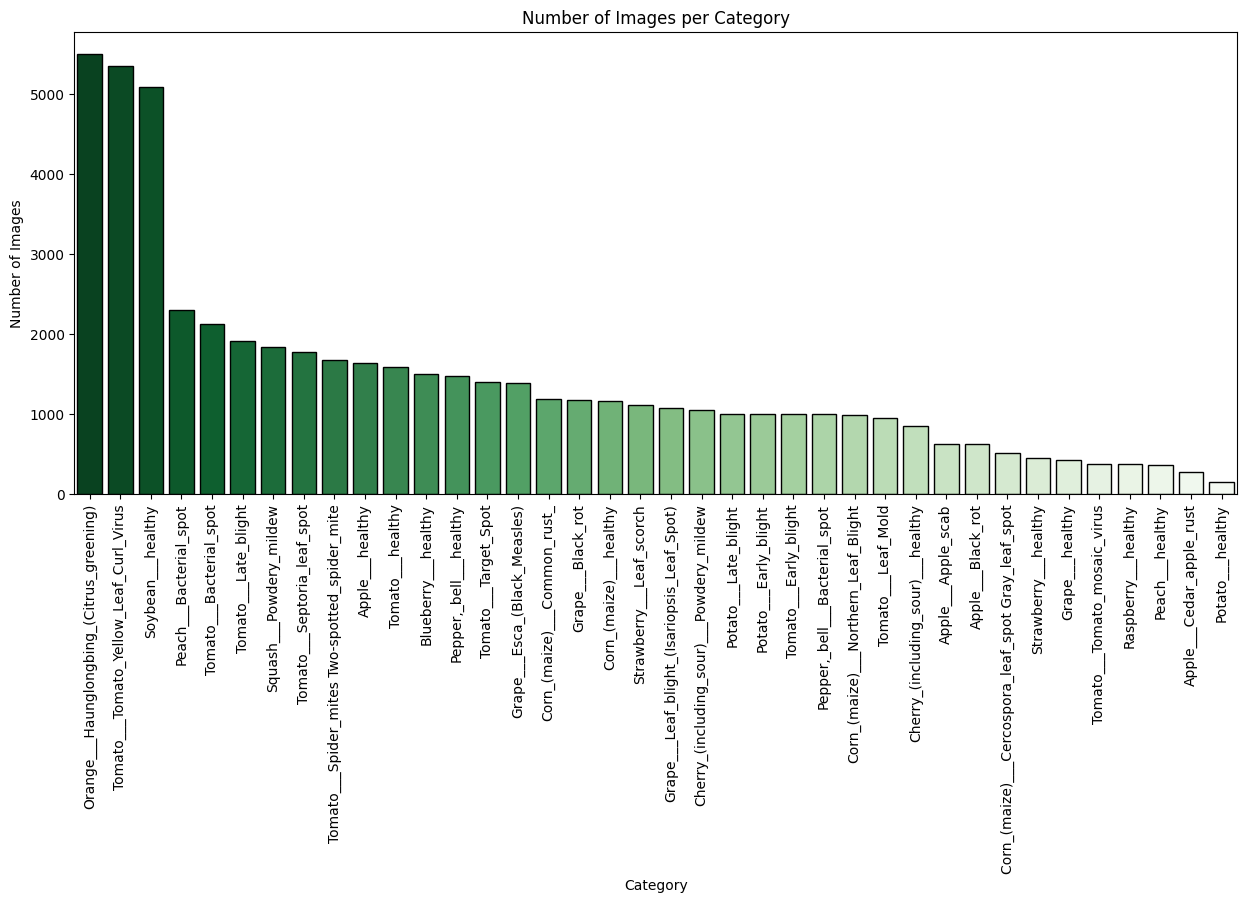

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(
    x='Category',
    y='Number of Images',
    data=df_counts,
    hue='Category',
    palette='Greens_r',
    edgecolor='black'
)

plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Number of Images per Category")
plt.show()

### **Dataset Analysis: Key Insights & Actions**

| Insight | Observation | Recommended Action |
| :--- | :--- | :--- |
| **🍎 Class Imbalance** | Extreme variance in samples (e.g., 5,507 vs. 152 images). | Use **hybrid methods** like class weighting or oversampling (e.g.,Augmentation&Class Weight) for minority classes. |
| **🍅 Tomato Dominance** | Tomato diseases are highly represented in the dataset. | Model will excel on tomatoes but needs augmented data for underrepresented crops (e.g., potato, grape). |
| **🌿 Disease Diversity** | Wide variety of diseases and healthy states across species. | Excellent for building a **general-purpose model** for plant disease diagnosis. |
| **✅ Healthy Representation** | Inconsistent healthy sample counts (e.g., Soybean: 5,090 vs. Potato: 152). | Apply **targeted augmentation** (rotations, flips, lighting changes) for healthy classes with low samples. |

------

## **Image size distribution**

In [ ]:
sizes = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            img = Image.open(img_path)
            sizes.append(img.size)
        except:
           print(f" Problem with image: {img_path}")

size_counts = Counter(sizes)

print(f"Total images: {len(sizes)}")
print(f"Number of unique sizes: {len(size_counts)}")
print("Top 10 most common sizes:")
for size, count in size_counts.most_common(10):
    print(size, ":", count)

Total images: 54305
Number of unique sizes: 1
Top 10 most common sizes:
(256, 256) : 54305


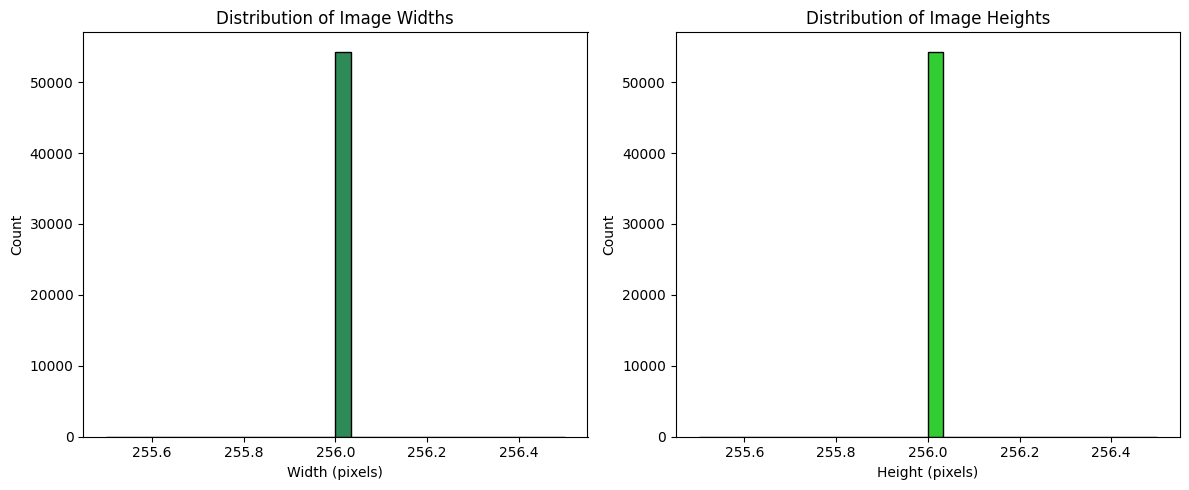

In [ ]:
widths = [w for (w, h) in sizes]
heights = [h for (w, h) in sizes]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30, color='seagreen', edgecolor='black')
plt.title("Distribution of Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color='limegreen', edgecolor='black')
plt.title("Distribution of Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

### **Image Size Standardization** 

- *Original Size:* All images pre-sized to 256×256 pixels
- *Processing:* Resized to 128×128 for efficiency
- *Benefits:*
  - *Faster training* with reduced computational requirements
  - *Lower memory usage* (RAM/GPU)
  - *Uniform input* for CNN models (EfficientNet, ResNet)
  - *Eliminates resolution bias* - no spurious size-related patterns
  - *Optimized batch processing* with consistent dimensions

---------

## **Healthy vs Diseased Pie Chart**

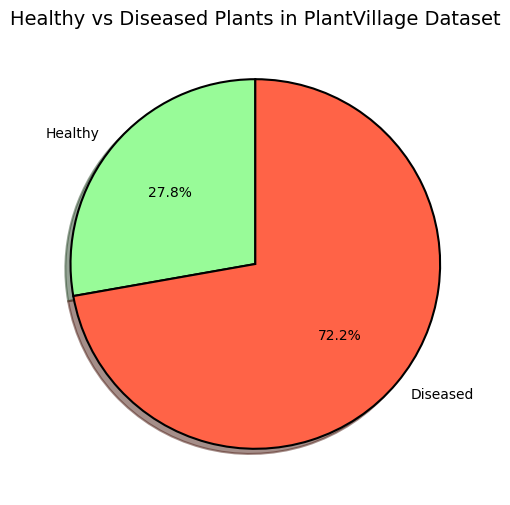

In [ ]:
healthy_count = df_counts[df_counts['Category'].str.contains("healthy", case=False)]['Number of Images'].sum()
diseased_count = df_counts['Number of Images'].sum() - healthy_count

summary_df = pd.DataFrame({
    "Condition": ["Healthy", "Diseased"],
    "Count": [healthy_count, diseased_count]
})


plt.figure(figsize=(6, 6))
colors = ['palegreen', 'tomato']
plt.pie( summary_df['Count'],
    labels=summary_df['Condition'],
    autopct='%1.1f%%',
    colors=colors,
    shadow=True,
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
plt.title("Healthy vs Diseased Plants in PlantVillage Dataset", fontsize=14)
plt.show()

### **Class Imbalance Alert** 

**-72.8% Diseased** vs. **27.2% Healthy** plants

**-Implication:** High risk of model bias toward predicting "diseased"

**-Solution:** Use class weights or oversampling during training

---------

# **Preprocessing & Dataset Class**

---



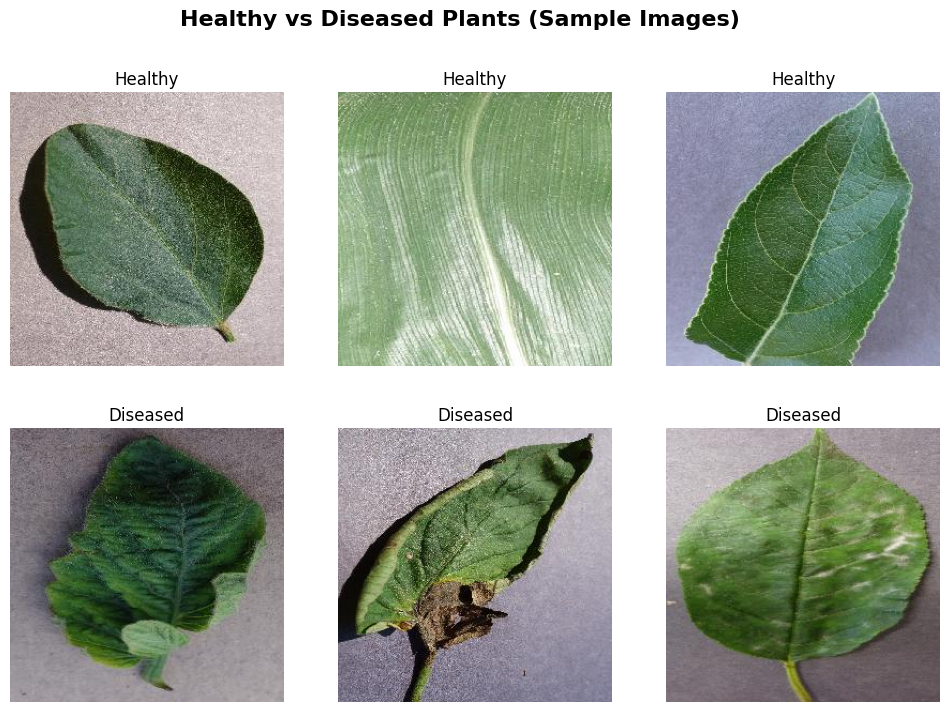

In [ ]:
healthy_cats = [c for c in os.listdir(data_dir) if "healthy" in c.lower()]
diseased_cats = [c for c in os.listdir(data_dir) if "healthy" not in c.lower()]

healthy_imgs = []
for cat in healthy_cats:
    files = os.listdir(os.path.join(data_dir, cat))
    healthy_imgs.extend([os.path.join(data_dir, cat, f) for f in files])

diseased_imgs = []
for cat in diseased_cats:
    files = os.listdir(os.path.join(data_dir, cat))
    diseased_imgs.extend([os.path.join(data_dir, cat, f) for f in files])


sample_healthy = random.sample(healthy_imgs, 3)
sample_diseased = random.sample(diseased_imgs, 3)


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, path in enumerate(sample_healthy):
    img = Image.open(path)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Healthy")
    axes[0, i].axis("off")

for i, path in enumerate(sample_diseased):
    img = Image.open(path)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Diseased")
    axes[1, i].axis("off")

plt.suptitle("Healthy vs Diseased Plants (Sample Images)", fontsize=16, fontweight="bold")
plt.show()

## **Normalization &Dataset & DataLoader**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()           # Normalization 0-1
])

#Dataset class
class PlantDataset(Dataset):
    def __init__(self, data_dir, categories, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        self.cat_to_idx = {cat: i for i, cat in enumerate(categories)}
        for category in categories:
            category_path = os.path.join(data_dir, category)
            for img_name in os.listdir(category_path):
                self.data.append(os.path.join(category_path, img_name))
                self.labels.append(self.cat_to_idx[category])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Dataset and DataLoader
dataset = PlantDataset(data_dir, categories, transform=transform)

# DataLoader batch by batch
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# batch
images, labels = next(iter(dataloader))
print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)

Batch shape: torch.Size([64, 3, 128, 128])
Labels shape: torch.Size([64])


## **Normalization Insights**

- **Image Preprocessing**  
  All images were resized to **(128×128)** : consistent input size, ready for the model.

- **Tensor Conversion**  
  Images converted to tensors with value range **[0, 1]** using ToTensor() : helps CNN training.

- **Custom Dataset Class**  
  Implemented a custom Dataset : dynamically loads images and maps categories to label indices.

- **Batching Configuration**  
  DataLoader returns batches of size **64**:  
  - Image shape : torch.Size([64, 3, 128, 128]) 
  - Label shape : torch.Size([64])

- **Shuffling**  
  shuffle=True : ensures random shuffling each epoch , reduces overfitting & improves generalization.
-------

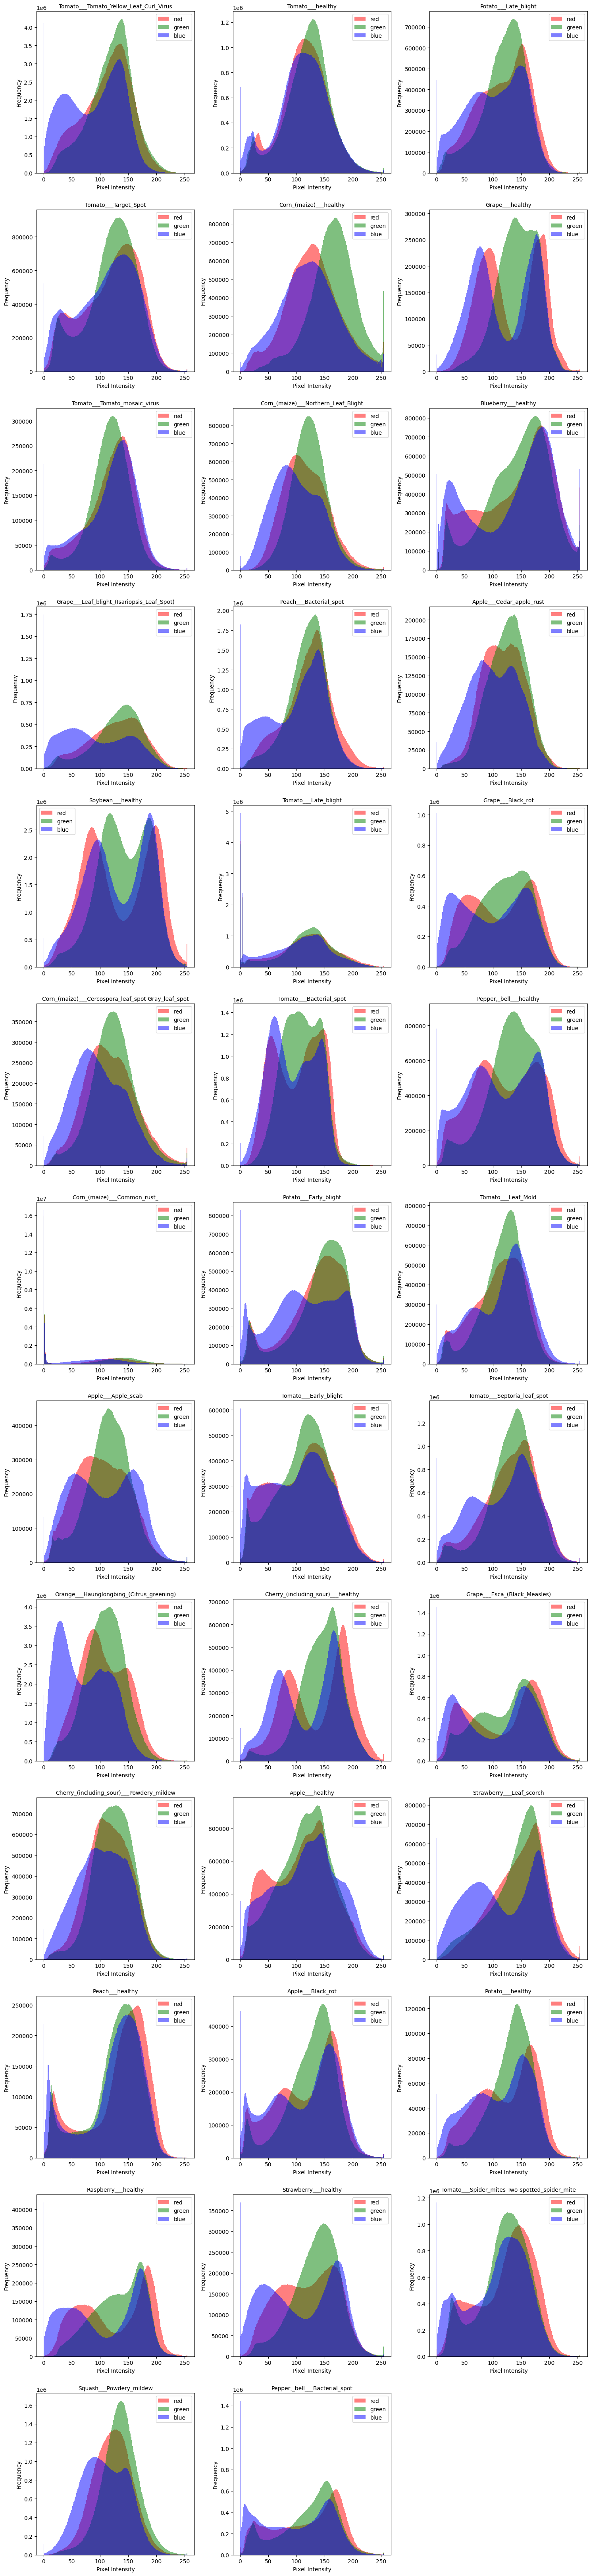

In [ ]:
num_categories = len(categories)
cols = 3
rows = (num_categories + cols - 1) // cols

plt.figure(figsize=(15, 5 * rows))

for idx, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    all_pixels = []

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img)
            all_pixels.append(img_array.reshape(-1, 3))
        except:
            print(f"Problem with image: {img_path}")

    if len(all_pixels) == 0:
        continue
    all_pixels = np.vstack(all_pixels)
    plt.subplot(rows, cols, idx+1)
    for i, color in enumerate(('red', 'green', 'blue')):
        plt.hist(all_pixels[:, i], bins=256, color=color, alpha=0.5, label=color)

    plt.title(category, fontsize=10)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

## **Insights from Color Distribution Analysis**

| Category type | Insights |
|---------------|----------|
| Easy to distinguish | Tomato / Strawberry (Red dominant), Spinach / Leafy (Green dominant), Blueberry / Grape Black rot (Blue/Dark dominant) |
| Hard to distinguish | Apple / Pear / Peach (similar RGB overlap) |
| Healthy vs Diseased | Diseased leaves/fruits often show darker shifts in distributions (e.g., Orange Haunglongbing, Grape Black rot) |
| Dataset quality | No extreme outliers, distributions look smooth → dataset is consistent |
| Preprocessing need | Apply Normalization/Standardization across channels |
| Augmentation potential | Use Color Jitter (brightness, contrast, saturation) to increase robustness |


# **Train / Validation / Test Split**

In [ ]:
all_imgs = dataset.data
all_labels = dataset.labels
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_imgs, all_labels,
    test_size=0.3,
    stratify=all_labels,
    random_state=42
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

In [ ]:
print(f"Train: {len(train_imgs)} images")
print(f"Val:   {len(val_imgs)} images")
print(f"Test:  {len(test_imgs)} images")

Train: 38013 images
Val:   8146 images
Test:  8146 images


# **SubsetDataset for Splits**

In [ ]:
class SubsetDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# **DataLoaders for (Train / Val / Test) and Hybird Approach**

In [ ]:
# Calculate class weights for imbalanced dataset
def calculate_class_weights(labels):
    class_counts = Counter(labels)
    total_samples = len(labels)
    num_classes = len(class_counts)

    # Calculate weights: inverse of class frequency
    weights = [total_samples / (num_classes * count) for count in class_counts.values()]

    # Normalize weights
    weights = torch.tensor(weights, dtype=torch.float32)
    weights = weights / weights.sum()

    return weights

# Calculate class weights
class_weights = calculate_class_weights(train_labels)
print("Class weights:", class_weights)

Class weights: tensor([0.0130, 0.0210, 0.0038, 0.0178, 0.0090, 0.0113, 0.0175, 0.0207, 0.0039,
        0.0117, 0.0333, 0.0140, 0.0126, 0.0041, 0.0242, 0.0108, 0.0174, 0.0186,
        0.0750, 0.0123, 0.0557, 0.0097, 0.0138, 0.0403, 0.0149, 0.1365, 0.0207,
        0.0207, 0.0147, 0.0207, 0.0197, 0.0192, 0.0328, 0.0489, 0.0574, 0.0217,
        0.0454, 0.0554])


# **Class Weights Analysis**

## -**Interpretation of Class Weights Distribution**

### **Overall Observation:**
The class weights show **significant imbalance** across the 38 plant disease categories, with weights ranging from **0.0038 to 0.1365** - representing a **36× difference** between the most and least frequent classes.

---

## **Key Insights:**

### **Highly Rare Classes** (Highest weights → Most attention)
- **Class 25: 0.1365** - Extremely rare category (likely very few samples)
- **Class 18: 0.0750** - Very rare category  
- **Class 34: 0.0574** - Very rare category
- **Class 37: 0.0554** - Very rare category

### **Very Common Classes** (Lowest weights → Least attention)
- **Class 2: 0.0038** - Extremely abundant category
- **Class 8: 0.0039** - Very abundant category
- **Class 13: 0.0041** - Very abundant category

### **Moderate Frequency Classes** (Middle weights)
- Most classes fall in the **0.0100-0.0300** range
- These represent moderately represented disease categories

---

## **Impact on Model Training:**

### **Loss Function Behavior**
- Errors on rare classes will be penalized **36× more heavily** than errors on common classes
- Prevents model from ignoring minority classes in favor of majority classes

### **Expected Benefits**  
- Better balance in classification performance across all disease types
- More robust and equitable plant disease classification model

---

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights=[class_weights[label] for label in train_labels],
    num_samples=len(train_labels),
    replacement=True)

In [ ]:
def get_augmentation_transform():
    return transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
class HybridTransform:
    def __init__(self, labels, base_transform, augment_transform):
        self.labels = labels
        self.base_transform = base_transform
        self.augment_transform = augment_transform

        class_counts = Counter(labels)
        avg_count = sum(class_counts.values()) / len(class_counts)
        self.augment_classes = {cls_idx for cls_idx, count in class_counts.items()
                               if count < avg_count * 0.7}

    def __call__(self, img, label):
        if label in self.augment_classes:
            return self.augment_transform(img)
        else:
            return self.base_transform(img)

In [ ]:
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
hybrid_transform = HybridTransform(
    train_labels,
    base_transform=base_transform,
    augment_transform=get_augmentation_transform())

In [ ]:
class HybridPlantDataset(Dataset):
    def __init__(self, imgs, labels, hybrid_transform=None):
        self.imgs = imgs
        self.labels = labels
        self.hybrid_transform = hybrid_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.hybrid_transform(img, label)
        return img, label
train_dataset = HybridPlantDataset(train_imgs, train_labels, hybrid_transform=hybrid_transform)
val_dataset = SubsetDataset(val_imgs, val_labels, transform=base_transform)
test_dataset = SubsetDataset(test_imgs, test_labels, transform=base_transform)

In [ ]:
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=weighted_sampler,
    num_workers=2,
    pin_memory=True)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True)

def check_class_distribution(loader, name):
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.numpy())
    distribution = Counter(all_labels)
    print(f"\n{name} class distribution:")
    for cls_idx, count in distribution.items():
        print(f"Class {cls_idx}: {count} samples")
    return distribution

train_dist = check_class_distribution(train_loader, "Training")
val_dist = check_class_distribution(val_loader, "Validation")
criterion = nn.CrossEntropyLoss(weight=class_weights)
print("Hybrid approach implemented")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Training class distribution:
Class 23: 2141 samples
Class 35: 1219 samples
Class 17: 845 samples
Class 26: 886 samples
Class 25: 3457 samples
Class 28: 772 samples
Class 14: 918 samples
Class 30: 233 samples
Class 37: 1676 samples
Class 12: 2060 samples
Class 22: 398 samples
Class 1: 1021 samples
Class 27: 713 samples
Class 36: 2581 samples
Class 10: 2324 samples
Class 18: 2771 samples
Class 7: 581 samples
Class 0: 2216 samples
Class 3: 765 samples
Class 24: 2608 samples
Class 34: 799 samples
Class 31: 361 samples
Class 29: 713 samples
Class 19: 400 samples
Class 9: 356 samples
Class 20: 1634 samples
Class 16: 1139 samples
Class 33: 584 samples
Class 21: 186 samples
Class 8: 197 samples
Class 13: 238 samples
Class 11: 113 samples
Class 4: 324 samples
Class 32: 150 samples
Class 6: 202 samples
Class 5: 156 samples
Class 15: 168 samples
Class 2: 108 samples

Validation class distribution:
Class 5: 64 samples
Class 8: 225 samples
Class 18: 179 samples
Class 12: 763 samples
Class 19: 150 

# **Hybrid Augmentation Strategy - Insights & Analysis**

### **Problem Identified:**
- **Severe class imbalance** detected across 38 plant disease categories
- Sample distribution ranges from **108 to 3,457 images per class** (32× difference)
- Risk of model bias toward majority classes

### **Solution Deployed:**
- **Hybrid augmentation approach** combining three techniques:
  1. **Class-weighted loss function** - Prioritizes rare classes
  2. **Weighted random sampling** - Balances batch composition  
  3. **Selective augmentation** - Targeted enhancement of minority classes only

---

## **Performance Insights**

### **Training Set Optimization**:
- **All 38 classes** maintained in training distribution
- **Rare classes (≤150 samples)** received intensive augmentation
- **Common classes (>1500 samples)** received minimal augmentation
- **Natural distribution preserved** while addressing imbalance

###**Validation Set**:
- **Complete class coverage** - All 38 categories represented
- **Reduced sample counts** - Expected reduction due to split ratio
- **Statistical challenges** - Some classes have limited samples (e.g., Class 32: 23 samples)

---


In [ ]:
print("Train loader batches:", len(train_loader))
print("Val loader batches:", len(val_loader))
print("Test loader batches:", len(test_loader))
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Train loader batches: 1188
Val loader batches: 255
Test loader batches: 255
Batch shape: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32])


/tmp/ipython-input-238579099.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])
/tmp/ipython-input-238579099.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])


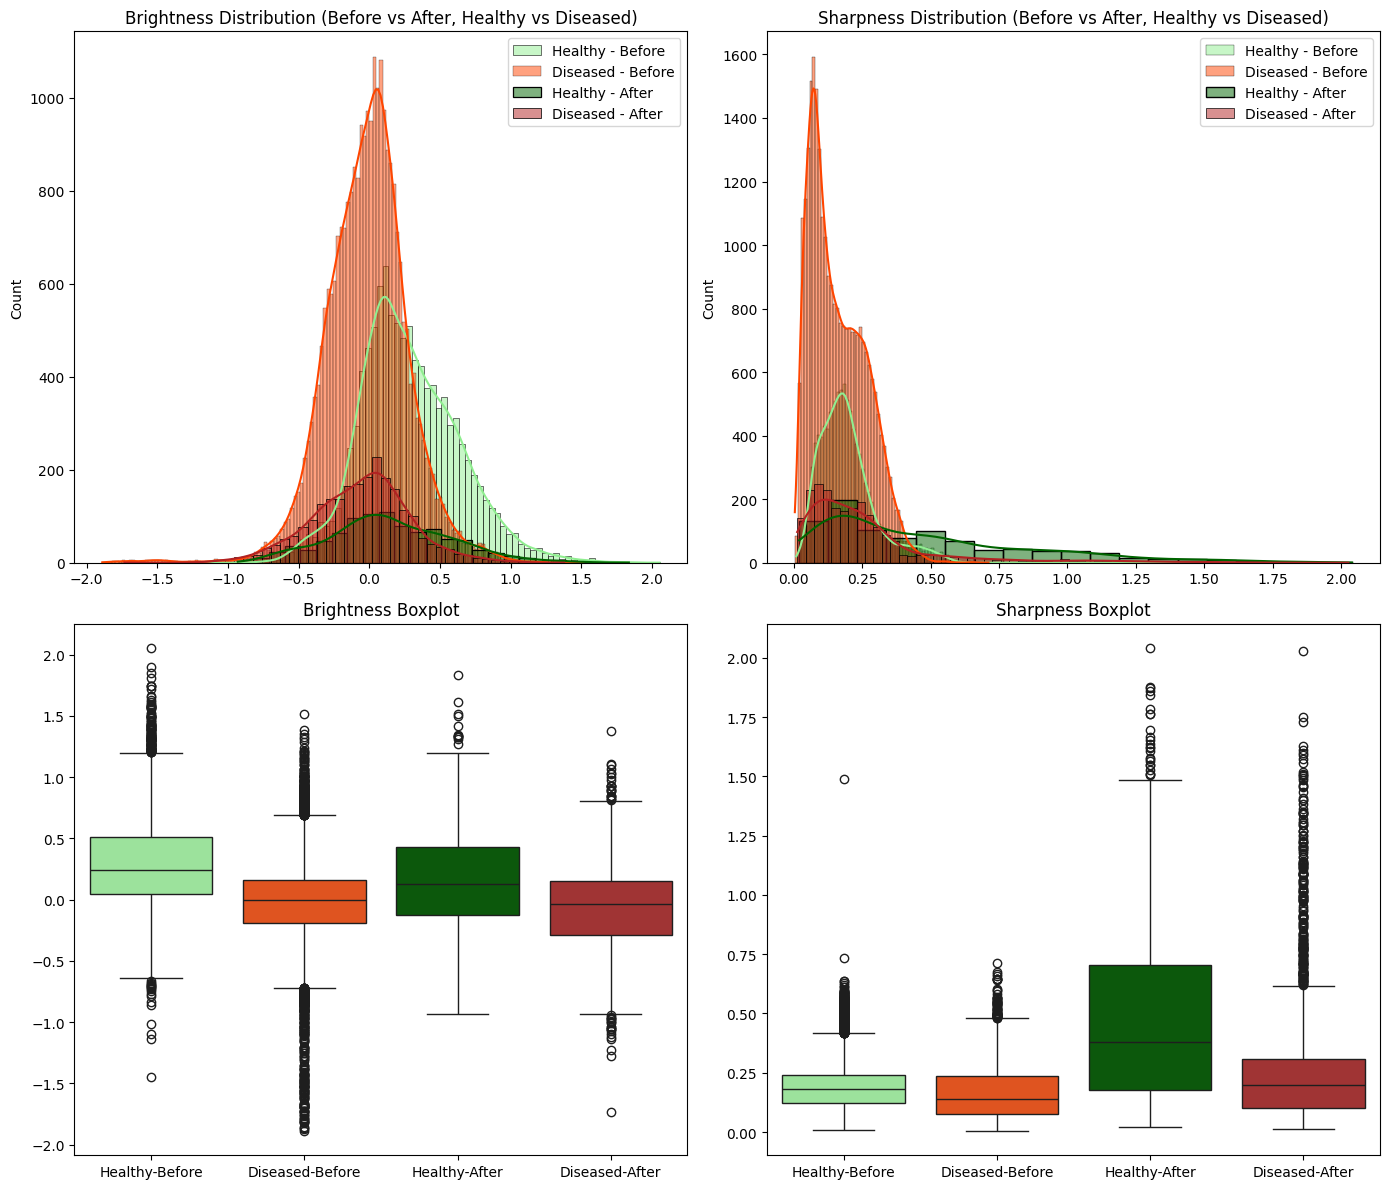

Healthy Avg Brightness (Before): 0.28
Healthy Avg Brightness (After):  0.15
Diseased Avg Brightness (Before): -0.01
Diseased Avg Brightness (After):  -0.06
Healthy Avg Sharpness (Before): 0.20
Healthy Avg Sharpness (After):  0.49
Diseased Avg Sharpness (Before): 0.16
Diseased Avg Sharpness (After):  0.27


In [ ]:
def calculate_brightness_sharpness(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    brightness = np.mean(gray)
    laplacian = (
        np.roll(gray, 1, 0) + np.roll(gray, -1, 0) +
        np.roll(gray, 1, 1) + np.roll(gray, -1, 1) - 4 * gray
    )
    sharpness = laplacian.var()
    return brightness, sharpness
brightness_healthy_before, sharpness_healthy_before = [], []
brightness_diseased_before, sharpness_diseased_before = [], []

for img_path, label in zip(train_imgs, train_labels):
    img = Image.open(img_path).convert("RGB")
    img = base_transform(img)

    brightness, sharpness = calculate_brightness_sharpness(img)
    if "healthy" in categories[label].lower():
        brightness_healthy_before.append(brightness)
        sharpness_healthy_before.append(sharpness)
    else:
        brightness_diseased_before.append(brightness)
        sharpness_diseased_before.append(sharpness)
brightness_healthy_after, sharpness_healthy_after = [], []
brightness_diseased_after, sharpness_diseased_after = [], []

for i, (images, labels) in enumerate(train_loader):
    for img, label in zip(images, labels):
        brightness, sharpness = calculate_brightness_sharpness(img)
        if "healthy" in categories[label.item()].lower():
            brightness_healthy_after.append(brightness)
            sharpness_healthy_after.append(sharpness)
        else:
            brightness_diseased_after.append(brightness)
            sharpness_diseased_after.append(sharpness)
    if i > 100:
        break
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Brightness distributions
sns.histplot(brightness_healthy_before, kde=True, ax=axes[0,0], color="lightgreen", label="Healthy - Before")
sns.histplot(brightness_diseased_before, kde=True, ax=axes[0,0], color="orangered", label="Diseased - Before")
sns.histplot(brightness_healthy_after, kde=True, ax=axes[0,0], color="darkgreen", label="Healthy - After")
sns.histplot(brightness_diseased_after, kde=True, ax=axes[0,0], color="firebrick", label="Diseased - After")
axes[0,0].set_title("Brightness Distribution (Before vs After, Healthy vs Diseased)")
axes[0,0].legend()

# Sharpness distributions
sns.histplot(sharpness_healthy_before, kde=True, ax=axes[0,1], color="lightgreen", label="Healthy - Before")
sns.histplot(sharpness_diseased_before, kde=True, ax=axes[0,1], color="orangered", label="Diseased - Before")
sns.histplot(sharpness_healthy_after, kde=True, ax=axes[0,1], color="darkgreen", label="Healthy - After")
sns.histplot(sharpness_diseased_after, kde=True, ax=axes[0,1], color="firebrick", label="Diseased - After")
axes[0,1].set_title("Sharpness Distribution (Before vs After, Healthy vs Diseased)")
axes[0,1].legend()

# Boxplots Brightness
sns.boxplot(data=[brightness_healthy_before, brightness_diseased_before,
                  brightness_healthy_after, brightness_diseased_after],
            palette=["lightgreen", "orangered", "darkgreen", "firebrick"], ax=axes[1,0])
axes[1,0].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])
axes[1,0].set_title("Brightness Boxplot")

# Boxplots Sharpness
sns.boxplot(data=[sharpness_healthy_before, sharpness_diseased_before,
                  sharpness_healthy_after, sharpness_diseased_after],
            palette=["lightgreen", "orangered", "darkgreen", "firebrick"], ax=axes[1,1])
axes[1,1].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])
axes[1,1].set_title("Sharpness Boxplot")

plt.tight_layout()
plt.show()

# Print stats
print(f"Healthy Avg Brightness (Before): {np.mean(brightness_healthy_before):.2f}")
print(f"Healthy Avg Brightness (After):  {np.mean(brightness_healthy_after):.2f}")
print(f"Diseased Avg Brightness (Before): {np.mean(brightness_diseased_before):.2f}")
print(f"Diseased Avg Brightness (After):  {np.mean(brightness_diseased_after):.2f}")

print(f"Healthy Avg Sharpness (Before): {np.mean(sharpness_healthy_before):.2f}")
print(f"Healthy Avg Sharpness (After):  {np.mean(sharpness_healthy_after):.2f}")
print(f"Diseased Avg Sharpness (Before): {np.mean(sharpness_diseased_before):.2f}")
print(f"Diseased Avg Sharpness (After):  {np.mean(sharpness_diseased_after):.2f}")

### **Insights from Brightness & Sharpness Analysis**

1. **Brightness**
   - Healthy images have **higher brightness** compared to Diseased images.  
     - Healthy (Before): 0.28 → (After): 0.15  
     - Diseased (Before): -0.01 → (After): -0.06  
   - Preprocessing reduces the brightness in both groups, but the difference between Healthy and Diseased remains noticeable.

2. **Sharpness**
   - Both Healthy and Diseased images become **sharper after preprocessing**, but the effect is stronger for Healthy images.  
     - Healthy (Before): 0.20 → (After): 0.49  
     - Diseased (Before): 0.16 → (After): 0.27  
   - This increase in sharpness may help the model better capture fine details in Healthy vs Diseased leaves.

3. **Overall Conclusion**
   - **Brightness**: Healthy leaves tend to be brighter than Diseased leaves.  
   - **Sharpness**: Preprocessing enhances clarity, especially in Healthy samples.  
   - Both features (Brightness & Sharpness) could serve as useful indicators for distinguishing between Healthy and Diseased plant images.
